INPUT DATA dan Packages

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
data = pd.read_excel('https://github.com/syachmhrd/DAS/blob/main/Soybean%20Indo%20FIX.xlsx?raw=true')

PreProcessing

In [4]:
data.head()

,Date,UBCurr,UBLast,AECurr,AELast,TCCurr,TCLast,% change,next year
0,2006-05-18,113.6,43.8,944.7,858.8,1058.0,903.0,17.250166,NaN
1,2006-05-25,58.9,43.8,1010.7,858.8,1070.0,903.0,18.502105,NaN
2,2006-06-01,57.8,43.8,1011.8,858.8,1070.0,903.0,18.502105,NaN
3,2006-06-08,57.0,4.8,1012.6,900.8,1070.0,906.0,18.109541,0.0
4,2006-06-15,61.5,4.8,1012.6,924.1,1074.0,929.0,15.631392,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       587 non-null    datetime64[ns]
 1   UBCurr     534 non-null    float64       
 2   UBLast     534 non-null    float64       
 3   AECurr     533 non-null    float64       
 4   AELast     534 non-null    float64       
 5   TCCurr     534 non-null    float64       
 6   TCLast     534 non-null    float64       
 7   % change   534 non-null    float64       
 8   next year  154 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 41.4 KB


In [6]:
data.index=data['Date']

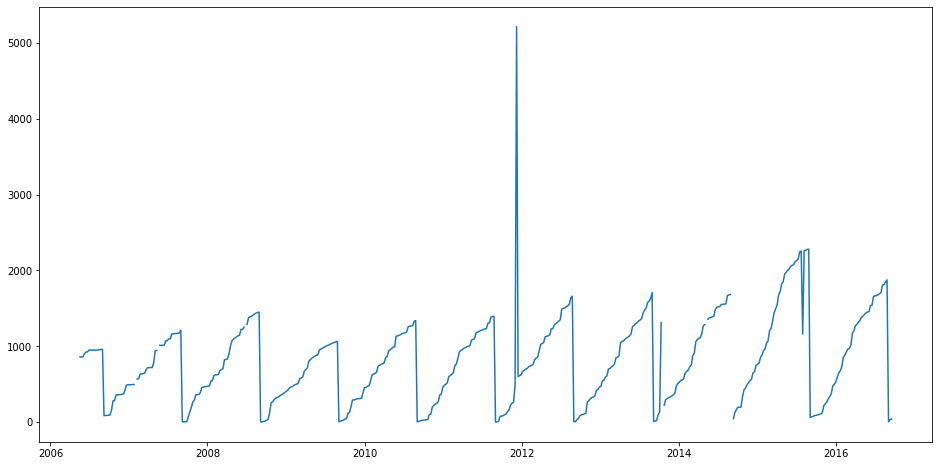

In [7]:
plt.figure(figsize=(16,8))
plt.plot(data['AELast'], label='AELast Price')

In [8]:
print(data.isnull().sum())
print(data.isnull().sum().sum())

Date           0
UBCurr        53
UBLast        53
AECurr        54
AELast        53
TCCurr        53
TCLast        53
% change      53
next year    433
dtype: int64
805


In [9]:
print(data['AELast'].describe())
print(data['AELast'].mode())

count     534.000000
mean      816.376030
std       563.877828
min         0.000000
25%       362.750000
50%       767.750000
75%      1171.775000
max      5216.700000
Name: AELast, dtype: float64
0    948.6
dtype: float64


In [10]:
data['AELast'] = data['AELast'].replace(np.nan, 816.4)

In [11]:
data = data.drop(['next year'], axis=1)
data = data.dropna(axis=0)

In [12]:
data.head()

,Date,UBCurr,UBLast,AECurr,AELast,TCCurr,TCLast,% change
Date,,,,,,,,
2006-05-18,2006-05-18,113.6,43.8,944.7,858.8,1058.0,903.0,17.250166
2006-05-25,2006-05-25,58.9,43.8,1010.7,858.8,1070.0,903.0,18.502105
2006-06-01,2006-06-01,57.8,43.8,1011.8,858.8,1070.0,903.0,18.502105
2006-06-08,2006-06-08,57.0,4.8,1012.6,900.8,1070.0,906.0,18.109541
2006-06-15,2006-06-15,61.5,4.8,1012.6,924.1,1074.0,929.0,15.631392


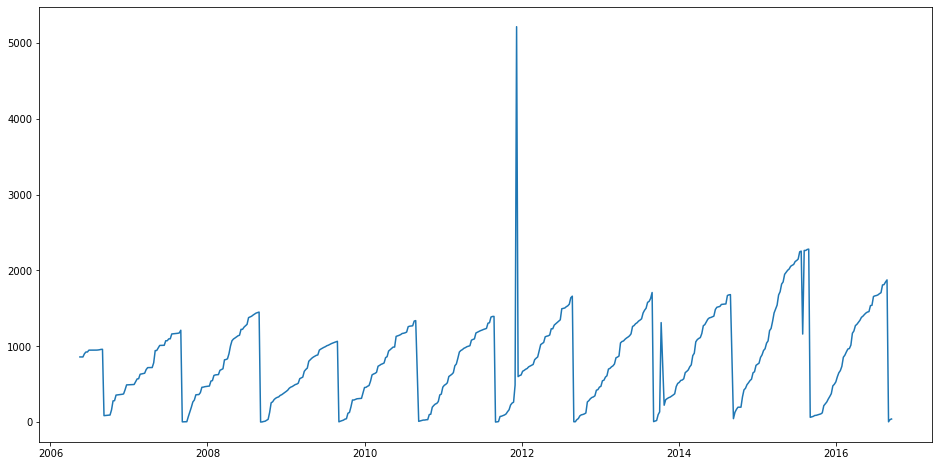

In [13]:
plt.figure(figsize=(16,8))
plt.plot(data['AELast'], label='AELast Price')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 533 entries, 2006-05-18 to 2016-09-15
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      533 non-null    datetime64[ns]
 1   UBCurr    533 non-null    float64       
 2   UBLast    533 non-null    float64       
 3   AECurr    533 non-null    float64       
 4   AELast    533 non-null    float64       
 5   TCCurr    533 non-null    float64       
 6   TCLast    533 non-null    float64       
 7   % change  533 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 37.5 KB


In [15]:
new_data=data.iloc[:,4:5].values

In [16]:
train_data=new_data[0:495,0]
valid_data=new_data[495:,0]

In [17]:
train_data.shape,valid_data.shape

((495,), (38,))

In [18]:
train_data=train_data.reshape(-1,1)

In [19]:
train_data.shape

(495, 1)

In [20]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_data)

In [21]:
#creating a data structure with 90 timesteps and 1 output
x_train = []
y_train = []

for i in range(90, 495):
  x_train.append(training_set_scaled[i-90:i,0])
  y_train.append(training_set_scaled[i,0])

#converting x_train and y_train into numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [22]:
x_train

array([[0.16462515, 0.16462515, 0.16462515, ..., 0.11781394, 0.1192133 ,
        0.11959668],
       [0.16462515, 0.16462515, 0.17267621, ..., 0.1192133 , 0.11959668,
        0.1200184 ],
       [0.16462515, 0.17267621, 0.17714264, ..., 0.11959668, 0.1200184 ,
        0.13077233],
       ...,
       [0.16796059, 0.17399889, 0.20277187, ..., 0.05077923, 0.0583319 ,
        0.06475358],
       [0.17399889, 0.20277187, 0.20852263, ..., 0.0583319 , 0.06475358,
        0.07184619],
       [0.20277187, 0.20852263, 0.21147469, ..., 0.06475358, 0.07184619,
        0.09134127]])

In [23]:
x_train.shape

(405, 90)

In [24]:
# reshaping dataset
x_train = x_train.reshape(405,90,1)

In [25]:
x_train.shape

(405, 90, 1)

In [26]:
y_train

array([1.20018402e-01, 1.30772327e-01, 1.32612571e-01, 1.34740353e-01,
       1.57245002e-01, 1.58126785e-01, 1.59909521e-01, 1.72848736e-01,
       1.92420496e-01, 2.05704756e-01, 2.10056166e-01, 2.12605670e-01,
       2.15500220e-01, 2.18126402e-01, 2.19544923e-01, 2.34420227e-01,
       2.34420227e-01, 2.39998466e-01, 2.47110242e-01, 2.64055821e-01,
       2.65838557e-01, 2.67582955e-01, 2.70554182e-01, 2.72911994e-01,
       2.75595683e-01, 2.76880020e-01, 2.78126018e-01, 0.00000000e+00,
       2.68368892e-04, 1.36101367e-03, 2.07027431e-03, 4.56227117e-03,
       6.86257596e-03, 2.43448924e-02, 4.86514463e-02, 5.11817816e-02,
       5.69517128e-02, 6.01913087e-02, 6.23190906e-02, 6.36034275e-02,
       6.73414227e-02, 6.90858205e-02, 7.18461863e-02, 7.44723676e-02,
       7.74244254e-02, 8.05298369e-02, 8.53988153e-02, 8.81783503e-02,
       8.97502252e-02, 9.22422221e-02, 9.46958805e-02, 9.59035406e-02,
       9.82613530e-02, 1.09686200e-01, 1.11564782e-01, 1.13635057e-01,
      

In [27]:
import tensorflow as tf

In [28]:
# define an object (inilitizing RNN)
model = tf.keras.models.Sequential()

In [29]:
# first LSTM layer
model.add(tf.keras.layers.LSTM(units=90, activation='relu', return_sequences=True, input_shape=(90,1)))
# dropout layer
model.add(tf.keras.layers.Dropout(0.2))

# second LSTM layer
model.add(tf.keras.layers.LSTM(units=90, activation='relu', return_sequences=True))
# dropout layer
model.add(tf.keras.layers.Dropout(0.2))

# third LSTM layer
model.add(tf.keras.layers.LSTM(units=180, activation='relu'))
# dropout layer
model.add(tf.keras.layers.Dropout(0.2))

In [30]:
# output layer
model.add(tf.keras.layers.Dense(units=1))

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 90)            33120     
_________________________________________________________________
dropout (Dropout)            (None, 90, 90)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 90)            65160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 180)               195120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 180)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [32]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
model.fit(x_train,y_train, batch_size=64, epochs=75,verbose=2)

Epoch 1/75
7/7 - 8s - loss: 0.0249
Epoch 2/75
7/7 - 3s - loss: 0.0132
Epoch 3/75
7/7 - 3s - loss: 0.0129
Epoch 4/75
7/7 - 3s - loss: 0.0123
Epoch 5/75
7/7 - 3s - loss: 0.0120
Epoch 6/75
7/7 - 3s - loss: 0.0117
Epoch 7/75
7/7 - 3s - loss: 0.0115
Epoch 8/75
7/7 - 3s - loss: 0.0111
Epoch 9/75
7/7 - 3s - loss: 0.0107
Epoch 10/75
7/7 - 3s - loss: 0.0106
Epoch 11/75
7/7 - 3s - loss: 0.0094
Epoch 12/75
7/7 - 3s - loss: 0.0087
Epoch 13/75
7/7 - 3s - loss: 0.0081
Epoch 14/75
7/7 - 3s - loss: 0.0076
Epoch 15/75
7/7 - 3s - loss: 0.0069
Epoch 16/75
7/7 - 3s - loss: 0.0061
Epoch 17/75
7/7 - 3s - loss: 0.0058
Epoch 18/75
7/7 - 3s - loss: 0.0057
Epoch 19/75
7/7 - 3s - loss: 0.0063
Epoch 20/75
7/7 - 3s - loss: 0.0061
Epoch 21/75
7/7 - 3s - loss: 0.0063
Epoch 22/75
7/7 - 3s - loss: 0.0054
Epoch 23/75
7/7 - 3s - loss: 0.0055
Epoch 24/75
7/7 - 3s - loss: 0.0048
Epoch 25/75
7/7 - 3s - loss: 0.0051
Epoch 26/75
7/7 - 3s - loss: 0.0048
Epoch 27/75
7/7 - 3s - loss: 0.0052
Epoch 28/75
7/7 - 3s - loss: 0.0052
E

In [34]:
valid_data

array([ 529.4,  596.4,  649.9,  678.8,  734.6,  854.8,  882.1,  925.4,
        963.2,  969.8, 1015.2, 1171.4, 1201.3, 1272.1, 1289.7, 1315.4,
       1342.3, 1381.1, 1396.8, 1419.1, 1438.7, 1451.4, 1456.5, 1536.2,
       1540.3, 1656.4, 1665.1, 1669.6, 1678.1, 1694.2, 1706.5, 1808.5,
       1813. , 1847.3, 1875.6,    3.1,   32.6,   40.2])

In [35]:
valid_data.shape

(38,)

In [36]:
valid_data = valid_data.reshape(-1,1)

In [37]:
valid_data

array([[ 529.4],
       [ 596.4],
       [ 649.9],
       [ 678.8],
       [ 734.6],
       [ 854.8],
       [ 882.1],
       [ 925.4],
       [ 963.2],
       [ 969.8],
       [1015.2],
       [1171.4],
       [1201.3],
       [1272.1],
       [1289.7],
       [1315.4],
       [1342.3],
       [1381.1],
       [1396.8],
       [1419.1],
       [1438.7],
       [1451.4],
       [1456.5],
       [1536.2],
       [1540.3],
       [1656.4],
       [1665.1],
       [1669.6],
       [1678.1],
       [1694.2],
       [1706.5],
       [1808.5],
       [1813. ],
       [1847.3],
       [1875.6],
       [   3.1],
       [  32.6],
       [  40.2]])

In [38]:
# Getting predicted accumulated soybean export at 2016

#concatination
data_total = data['AELast']

#stock prices of previous 90 days for each day of 2016
inputs = data_total[len(data_total)-len(valid_data)-90:].values

# reshape (convert into numpy array)
inputs = inputs.reshape(-1,1)

#feature scaling
inputs = sc.transform(inputs)

#creating a test set

x_test = []
for i in range(90,128):
  x_test.append(inputs[i-90:i,0])

# convert in numpy array
x_test = np.array(x_test)

# convert in 3D (required to process)
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],1))

# getting predicted stock prices
predicted_accumulated_export = model.predict(x_test)
predicted_accumulated_export = sc.inverse_transform(predicted_accumulated_export)

In [39]:
predicted_accumulated_export

array([[ 658.79193  ],
       [ 689.15375  ],
       [ 717.89594  ],
       [ 745.0752   ],
       [ 771.294    ],
       [ 798.62964  ],
       [ 832.59644  ],
       [ 884.3789   ],
       [ 955.9409   ],
       [1046.5999   ],
       [1149.0813   ],
       [1252.7859   ],
       [1348.7974   ],
       [1433.1414   ],
       [1498.7972   ],
       [1541.7355   ],
       [1559.2318   ],
       [1551.3595   ],
       [1528.0654   ],
       [1498.168    ],
       [1467.7819   ],
       [1454.384    ],
       [1479.8801   ],
       [1524.0154   ],
       [1564.0525   ],
       [1595.3408   ],
       [1619.3909   ],
       [1632.1892   ],
       [1641.2114   ],
       [1662.0751   ],
       [1715.5388   ],
       [1708.55     ],
       [ 941.9469   ],
       [ 128.62682  ],
       [  10.291691 ],
       [  -6.682392 ],
       [  -6.906939 ],
       [  -1.9777893]], dtype=float32)

In [40]:
print(predicted_accumulated_export[5]), print(valid_data[5])

[798.62964]
[854.8]


(None, None)

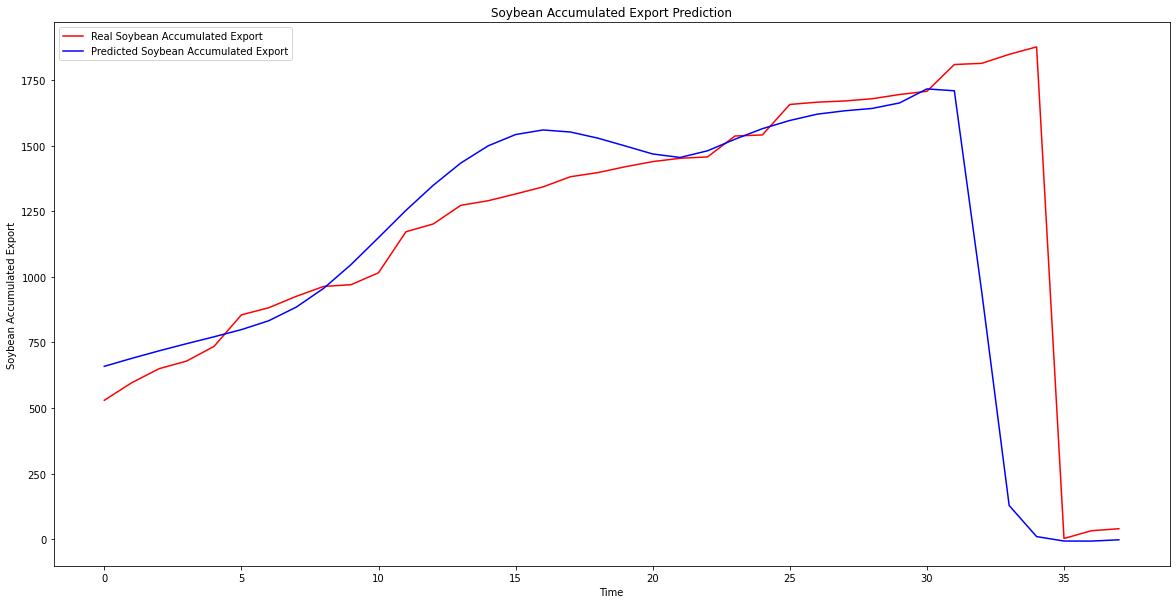

In [41]:
# Visualising the results
plt.plot(valid_data, color='red', label = 'Real Soybean Accumulated Export')
plt.plot(predicted_accumulated_export, color='blue', label = 'Predicted Soybean Accumulated Export')
plt.title('Soybean Accumulated Export Prediction')
plt.xlabel('Time')
plt.ylabel('Soybean Accumulated Export')
plt.legend()
plt.show()

In [42]:
ds= data[['Date','AELast']]

In [43]:
ds.head()

,Date,AELast
Date,,
2006-05-18,2006-05-18,858.8
2006-05-25,2006-05-25,858.8
2006-06-01,2006-06-01,858.8
2006-06-08,2006-06-08,900.8
2006-06-15,2006-06-15,924.1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


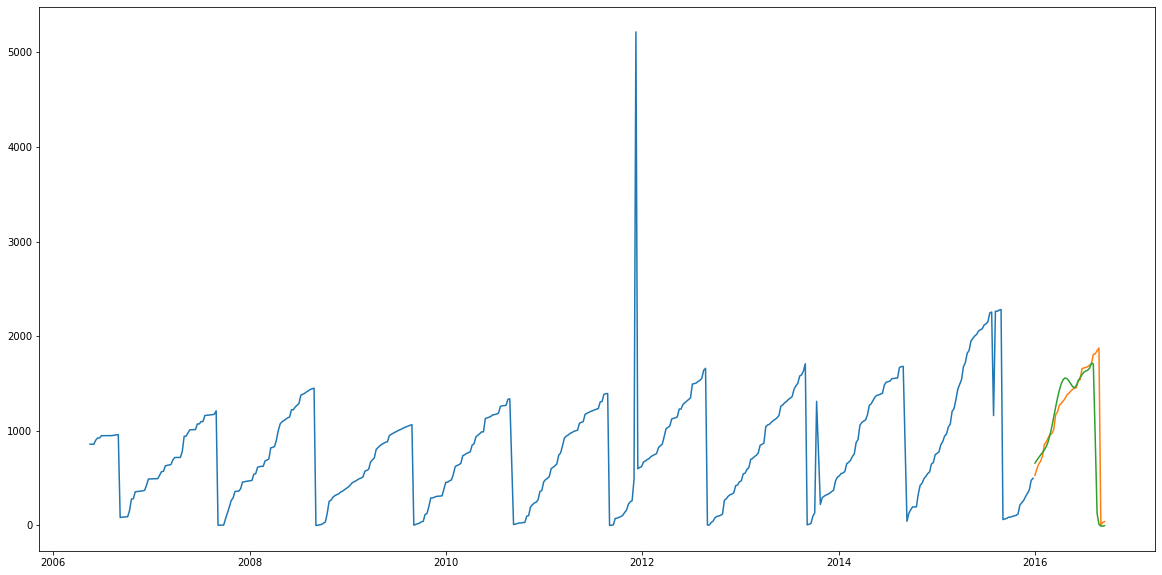

In [44]:
tr_data=ds[:495]
va_data=data[495:]
va_data['Predictions']=predicted_accumulated_export
plt.plot(tr_data["AELast"])
plt.plot(va_data[['AELast',"Predictions"]])

In [45]:
import math
MSE = np.square(np.subtract(valid_data,predicted_accumulated_export)).mean()

RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

445.2332739403152


In [46]:
from sklearn.metrics import mean_squared_error

In [47]:
mean_squared_error(valid_data,predicted_accumulated_export)

198232.66822361178

In [48]:
print(MSE)

198232.66822361178


In [49]:
MAPE = np.mean(np.abs((valid_data-predicted_accumulated_export) / valid_data))*100

In [50]:
MAPE

26.832778892364345